<a href="https://colab.research.google.com/github/NguyenNgocBaoNgan/Fake-news-detection-model-using-DT-SGD-Bagging/blob/main/Fake_news_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#tải dữ liệu
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Tiểu luận 2024'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Tiểu luận 2024


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from prettytable import PrettyTable
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import tree
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from scipy.stats import randint


**Dataset Link**
1.   BuzzFeed Political News Data set và Random Political News Data set [link](https://github.com/BenjaminDHorne/fakenewsdata1)
2.   Random Political News Data set [link](https://www.kaggle.com/datasets/csmalarkodi/isot-fake-news-dataset)



In [ ]:
data = pd.read_csv("BuzzFeed Political News Data set.csv",na_values='?',names =['Content','Label'])
data1 = pd.read_csv("Random Political News Data set.csv",na_values='?',names =['Content','Label'],sep=",", encoding='cp1252')
# load csv IOST files to dataframes
fake_df= pd.read_csv('ISOT Fake News Data set/Fake.csv')
real_df= pd.read_csv('ISOT Fake News Data set/True.csv')


In [ ]:
# Thay đổi các giá trị 'Fake' thành 0 và 'Real' thành 1 trong cột 'Label'
data['Label'] = data['Label'].replace({'Fake': 0, 'Real': 1})
# In ra dữ liệu sau khi thay đổi
data1['Label'] = data1['Label'].replace({'Fake': 0, 'Real': 1})
# In ra dữ liệu sau khi thay đổi
print(data1)

                                               Content  Label
0    A quick trip down memory lane causes a stumble...      0
1    Donald Trump was promised a smooth and respect...      0
2    Turkey’s President Recep Erdogan has come out ...      0
3    On Tuesday, the Times of Israel reported that ...      0
4    Since 2008 Obama and Democrats lost white work...      0
..                                                 ...    ...
145  As he traveled the country on his thank you to...      1
146  A federal judge in New York has unsealed the s...      1
147  On Sunday evening, Donald Trump invited report...      1
148  WASHINGTON -- Allegations of retaliation again...      1
149  A group of millennial activists from across th...      1

[150 rows x 2 columns]


In [ ]:
fake_df = fake_df[['title', 'text']]
real_df = real_df[['title', 'text']]

fake_df['Label'] = 0
real_df['Label'] = 1

data2 = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
data2.head(10)

,title,text,Label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,0
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,0


In [ ]:
data2.shape

(44898, 3)

In [ ]:
data2['Content'] = data2['title'] + ' ' + data2['text']
data2.drop(['title', 'text'], axis=1, inplace=True)
data2.head()

,Label,Content
0,0,Donald Trump Sends Out Embarrassing New Year’...
1,0,Drunk Bragging Trump Staffer Started Russian ...
2,0,Sheriff David Clarke Becomes An Internet Joke...
3,0,Trump Is So Obsessed He Even Has Obama’s Name...
4,0,Pope Francis Just Called Out Donald Trump Dur...


**Data preprocessing**

Tokenization: Chia dữ liệu văn bản thành các phần nhỏ hơn gọi là tokens và loại bỏ tất cả các dấu câu.

Lọc số: Loại bỏ các từ chứa số.

Chuyển đổi thành chữ thường: Chuyển đổi tất cả các từ thành chữ thường.

Lọc theo số ký tự: Loại bỏ các từ có ít hơn N ký tự.

In [ ]:
# Tải tài nguyên stop words tiếng Anh từ thư viện nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def preprocess_text(text):
    """Preprocesses a text by tokenization, removing punctuation, filtering out digits,
    filtering by word length, converting to lowercase, removing HTML tags,
    removing stop words, and stemming."""

    # Tokenization and removing punctuation
    tokens = re.findall(r'\b\w+\b', text)

    # Removing digits
    tokens = [word for word in tokens if not any(char.isdigit() for char in word)]

    # Filtering by word length
    N = 3  # Minimum word length
    tokens = [word for word in tokens if len(word) >= N]

    # Converting to lowercase
    tokens = [word.lower() for word in tokens]

    # Removing HTML tags
    text = re.sub(r'<[^>]*>', '', text)

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens


In [ ]:
# Apply the preprocessing function to the 'Content' column
data['Content_tokens'] = data['Content'].apply(preprocess_text)
data1['Content_tokens'] = data1['Content'].apply(preprocess_text)
data2['Content_tokens'] = data2['Content'].apply(preprocess_text)

# Display the preprocessed data
print(data2)

       Label                                            Content  \
0          0   Donald Trump Sends Out Embarrassing New Year’...   
1          0   Drunk Bragging Trump Staffer Started Russian ...   
2          0   Sheriff David Clarke Becomes An Internet Joke...   
3          0   Trump Is So Obsessed He Even Has Obama’s Name...   
4          0   Pope Francis Just Called Out Donald Trump Dur...   
...      ...                                                ...   
44893      1  'Fully committed' NATO backs new U.S. approach...   
44894      1  LexisNexis withdrew two products from Chinese ...   
44895      1  Minsk cultural hub becomes haven from authorit...   
44896      1  Vatican upbeat on possibility of Pope Francis ...   
44897      1  Indonesia to buy $1.14 billion worth of Russia...   

                                          Content_tokens  
0      [donald, trump, send, embarrass, new, year, ev...  
1      [drunk, brag, trump, staffer, start, russian, ...  
2      [sheriff, d

Use TF to extract the feature from the data
set.

In [ ]:
#Data set 1 – BuzzFeed Political News Data set
import pandas as pd
from collections import Counter

# Giả định `data` là DataFrame chứa các document và `Content_tokens` là cột chứa danh sách các token trong mỗi document

# Tạo một Counter object để đếm tần suất xuất hiện của các token
token_counter = Counter()

# Đếm tần suất xuất hiện của các token trong toàn bộ dữ liệu
for tokens in data['Content_tokens']:
    token_counter.update(tokens)

# Chọn các token có tần suất xuất hiện lớn hơn 30
selected_tokens = {token: count for token, count in token_counter.items() if count > 30}

# Tính giá trị TF cho mỗi token trong mỗi document
for i, tokens in enumerate(data['Content_tokens']):
    tf_values = {token: tokens.count(token) / len(tokens) for token in selected_tokens.keys()}
    # Tạo danh sách giá trị TF theo thứ tự của selected_tokens
    tf_list = [tf_values[token] if token in tf_values else 0 for token in selected_tokens.keys()]
    data.at[i, 'Content_tokens'] = tf_list

# In ra dữ liệu sau khi thay thế
print(data)

# Tạo DataFrame từ dữ liệu TF
dtm = pd.DataFrame(list(data['Content_tokens']))

# Đặt lại tên cột để thể hiện các term
dtm.columns = list(selected_tokens.keys())

# In ra DTM
print(dtm)


                                               Content  Label  \
0    The list of Republicans supporting Hillary Cli...      1   
1    CLEVELAND — Avik Roy is a Republican’s Republi...      1   
2    All politicians bend the truth to fit their pu...      1   
3    ’m cool with you removing me from your friends...      1   
4    “DON’T go anywhere near a mosque,” I told my m...      1   
..                                                 ...    ...   
96   Ottawa | Prime Minister Justin Trudeau is gett...      0   
97   Khizr Khan, the Muslim Gold Star father that t...      0   
98   Authors Darwin Porter and Danforth Prince have...      0   
99   Indianapolis, IN — Some are calling Donald Tru...      0   
100  Washington, D.C. – South African Billionaire, ...      0   

                                        Content_tokens  
0    [0.003067484662576687, 0.013803680981595092, 0...  
1    [0.0, 0.02927400468384075, 0.0, 0.0, 0.0, 0.0,...  
2    [0.0010224948875255625, 0.00511247443762781

In [ ]:
X = dtm.values
y = data['Label'].values
y = y.ravel()

In [ ]:
# normalize data
scaler  = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=123)


In [ ]:
# Tối ưu thuật toán bằng cách dùng GridSearchCV để tìm ra tham số tối ưu
sgd = SGDClassifier(random_state=123)

# Định nghĩa các giá trị tham số để tìm kiếm
param_grid = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'max_iter': [1000, 2000, 3000],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 1]  # Chỉ thêm eta0 với giá trị hợp lệ
}

# Khởi tạo GridSearchCV với 5-fold cross-validation
grid_search = GridSearchCV(estimator=sgd, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1', error_score=np.nan)

# Huấn luyện GridSearchCV trên tập huấn luyện
grid_search.fit(X_train, y_train)

# Lấy tham số tốt nhất
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'alpha': 0.01, 'eta0': 1, 'learning_rate': 'adaptive', 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}


In [ ]:
# Sử dụng các tham số tối ưu để khởi tạo lại mô hình SGD
best_sgd = SGDClassifier(alpha= 0.01, eta0= 1, learning_rate= 'adaptive', loss= 'hinge', max_iter=1000, penalty= 'l2', random_state= 42)
best_sgd.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_sgd = best_sgd.predict(X_test)

# Đánh giá mô hình
acc_sgd = accuracy_score(y_test, y_pred_sgd)
precision_sgd = precision_score(y_test, y_pred_sgd)
recall_sgd = recall_score(y_test, y_pred_sgd)
f1_sgd = f1_score(y_test, y_pred_sgd)

print("Accuracy:", acc_sgd)
print("Precision:", precision_sgd)
print("Recall:", recall_sgd)
print("F1 Score:", f1_sgd)

Accuracy: 0.7419354838709677
Precision: 0.7368421052631579
Recall: 0.8235294117647058
F1 Score: 0.7777777777777778


In [ ]:
# Tạo mô hình Decision Tree Classifier
clf = tree.DecisionTreeClassifier(random_state= 42)

# Định nghĩa các giá trị tham số để tìm kiếm
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Khởi tạo GridSearchCV với 5-fold cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1', error_score=np.nan)

# Huấn luyện GridSearchCV trên tập huấn luyện
grid_search.fit(X_train, y_train)

# Lấy tham số tốt nhất
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10}


In [ ]:
best_clf = tree.DecisionTreeClassifier(criterion= 'entropy', max_depth= None, max_features='log2', min_samples_leaf=1, min_samples_split= 10, random_state= 42)
best_clf.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_tree = best_clf.predict(X_test)

# Đánh giá mô hình
acc_tree = accuracy_score(y_test, y_pred_tree)
precision_tree = precision_score(y_test, y_pred_tree)
recall_tree = recall_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)

# In ra các giá trị
print("Accuracy:", acc_tree)
print("Precision:", precision_tree)
print("Recall:", recall_tree)
print("F1 Score:", f1_tree)

# Plot cây quyết định (nếu cần)
# from sklearn.tree import plot_tree
# import matplotlib.pyplot as plt
# plot_tree(best_clf)
# plt.show()

Accuracy: 0.6451612903225806
Precision: 0.6875
Recall: 0.6470588235294118
F1 Score: 0.6666666666666667


In [ ]:
# Tạo mô hình cây quyết định
base_estimator = tree.DecisionTreeClassifier()

# Tạo BaggingClassifier với tham số 'estimator'
bagging = BaggingClassifier(estimator=base_estimator, random_state=123)

# Định nghĩa lưới tham số cho GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(estimator=bagging, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)

# Kết quả tốt nhất
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# In kết quả
print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'estimator__max_depth': None, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score:  0.8


In [ ]:
# Sử dụng mô hình tốt nhất để dự đoán trên tập kiểm tra
best_bagging = grid_search.best_estimator_
y_pred_bagging = best_bagging.predict(X_test)

# Đánh giá mô hình
acc_bagging = accuracy_score(y_test, y_pred_bagging)
precision_bagging = precision_score(y_test, y_pred_bagging)
recall_bagging = recall_score(y_test, y_pred_bagging)
f1_bagging = f1_score(y_test, y_pred_bagging)

# In ra các giá trị
print("Accuracy:", acc_bagging)
print("Precision:", precision_bagging)
print("Recall:", recall_bagging)
print("F1 Score:", f1_bagging)

Accuracy: 0.6451612903225806
Precision: 0.6875
Recall: 0.6470588235294118
F1 Score: 0.6666666666666667


In [ ]:
#Data set 2 – Random Political News Data set
# Tạo một Counter object để đếm tần suất xuất hiện của các token
token_counter = Counter()

# Đếm tần suất xuất hiện của các token trong toàn bộ dữ liệu
for tokens in data1['Content_tokens']:
    token_counter.update(tokens)

# Chọn các token có tần suất xuất hiện lớn hơn 55
selected_tokens = {token: count for token, count in token_counter.items() if count > 55}
print(data1)

# Tính giá trị TF cho mỗi token trong mỗi document
for i, tokens in enumerate(data1['Content_tokens']):
    tf_values = {token: tokens.count(token) / len(tokens) for token in selected_tokens.keys()}
    # Tạo danh sách giá trị TF theo thứ tự của selected_tokens
    tf_list = [tf_values[token] if token in tf_values else 0 for token in selected_tokens.keys()]
    data1.at[i, 'Content_tokens'] = tf_list

# In ra dữ liệu sau khi thay thế
print(data1)

# Tạo DataFrame từ dữ liệu TF
dtm1 = pd.DataFrame(list(data1['Content_tokens']))

# Đặt lại tên cột để thể hiện các term
dtm1.columns = list(selected_tokens.keys())

# In ra DTM
print(dtm1)


                                               Content  Label  \
0    A quick trip down memory lane causes a stumble...      0   
1    Donald Trump was promised a smooth and respect...      0   
2    Turkey’s President Recep Erdogan has come out ...      0   
3    On Tuesday, the Times of Israel reported that ...      0   
4    Since 2008 Obama and Democrats lost white work...      0   
..                                                 ...    ...   
145  As he traveled the country on his thank you to...      1   
146  A federal judge in New York has unsealed the s...      1   
147  On Sunday evening, Donald Trump invited report...      1   
148  WASHINGTON -- Allegations of retaliation again...      1   
149  A group of millennial activists from across th...      1   

                                        Content_tokens  
0    [quick, trip, memori, lane, caus, stumbl, gem,...  
1    [donald, trump, promis, smooth, respect, trans...  
2    [turkey, presid, recep, erdogan, come, swin

In [ ]:
X1 = dtm1.values
y1 = data1['Label'].values
y1 = y1.ravel()

In [ ]:
# normalize data
scaler  = StandardScaler()
X1 = scaler.fit_transform(X1)
X_train1, X_test1, y_train1, y_test1 = model_selection.train_test_split(X1, y1, test_size=0.3, random_state=123)


In [ ]:
# Tối ưu thuật toán bằng cách dùng GridSearchCV để tìm ra tham số tối ưu
sgd1 = SGDClassifier(random_state=42)

# Định nghĩa các giá trị tham số để tìm kiếm
param_grid = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'max_iter': [1000, 2000, 3000],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 1]  # Chỉ thêm eta0 với giá trị hợp lệ
}

# Khởi tạo GridSearchCV với 5-fold cross-validation
grid_search1 = GridSearchCV(estimator=sgd1, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1', error_score=np.nan)

# Huấn luyện GridSearchCV trên tập huấn luyện
grid_search1.fit(X_train1, y_train1)

# Lấy tham số tốt nhất
best_params1 = grid_search1.best_params_
print("Best parameters found: ", best_params1)

Best parameters found:  {'alpha': 0.1, 'eta0': 1, 'learning_rate': 'invscaling', 'loss': 'log_loss', 'max_iter': 1000, 'penalty': 'l2'}


In [ ]:
# Sử dụng các tham số tối ưu để khởi tạo lại mô hình SGD
best_sgd1 = SGDClassifier(alpha= 0.1, eta0= 1, learning_rate= 'invscaling', loss= 'log_loss', max_iter=1000, penalty= 'l2', random_state=42)
best_sgd1.fit(X_train1, y_train1)

# Dự đoán trên tập kiểm tra
y_pred_sgd1 = best_sgd1.predict(X_test1)

# Đánh giá mô hình
acc_sgd1 = accuracy_score(y_test1, y_pred_sgd1)
precision_sgd1 = precision_score(y_test1, y_pred_sgd1)
recall_sgd1 = recall_score(y_test1, y_pred_sgd1)
f1_sgd1 = f1_score(y_test1, y_pred_sgd1)

print("Accuracy:", acc_sgd1)
print("Precision:", precision_sgd1)
print("Recall:", recall_sgd1)
print("F1 Score:", f1_sgd1)

Accuracy: 0.7555555555555555
Precision: 0.7037037037037037
Recall: 0.8636363636363636
F1 Score: 0.7755102040816326


In [ ]:
# Tạo mô hình Decision Tree Classifier
clf1 = tree.DecisionTreeClassifier(random_state= 123)

# Định nghĩa các giá trị tham số để tìm kiếm
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Khởi tạo GridSearchCV với 5-fold cross-validation
grid_search1 = GridSearchCV(estimator=clf1, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1', error_score=np.nan)

# Huấn luyện GridSearchCV trên tập huấn luyện
grid_search1.fit(X_train1, y_train1)

# Lấy tham số tốt nhất
best_params1 = grid_search1.best_params_
print("Best parameters found: ", best_params1)

Best parameters found:  {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [ ]:
best_clf1 = tree.DecisionTreeClassifier(criterion= 'gini', max_depth= None, max_features=None, min_samples_leaf=4, min_samples_split= 10, random_state= 123)
best_clf1.fit(X_train1, y_train1)

# Dự đoán trên tập kiểm tra
y_pred_tree1 = best_clf1.predict(X_test1)

# Đánh giá mô hình
acc_tree1 = accuracy_score(y_test1, y_pred_tree1)
precision_tree1 = precision_score(y_test1, y_pred_tree1)
recall_tree1 = recall_score(y_test1, y_pred_tree1)
f1_tree1 = f1_score(y_test1, y_pred_tree1)

# In ra các giá trị
print("Accuracy:", acc_tree1)
print("Precision:", precision_tree1)
print("Recall:", recall_tree1)
print("F1 Score:", f1_tree1)

# Plot cây quyết định
# from sklearn.tree import plot_tree
# import matplotlib.pyplot as plt
# plot_tree(best_clf)
# plt.show()

Accuracy: 0.6444444444444445
Precision: 0.625
Recall: 0.6818181818181818
F1 Score: 0.6521739130434783


In [ ]:
# Tạo mô hình cây quyết định
base_estimator = tree.DecisionTreeClassifier()

# Tạo BaggingClassifier với tham số 'estimator'
bagging = BaggingClassifier(estimator=base_estimator, random_state=123)

# Định nghĩa lưới tham số cho GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(estimator=bagging, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Huấn luyện GridSearchCV
grid_search.fit(X_train1, y_train1)

# Kết quả tốt nhất
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# In kết quả
print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score:  0.8095238095238095


In [ ]:
# Sử dụng mô hình tốt nhất để dự đoán trên tập kiểm tra
best_bagging1 = grid_search.best_estimator_
y_pred_bagging= best_bagging1.predict(X_test1)

# Đánh giá mô hình
acc_bagging1 = accuracy_score(y_test1, y_pred_bagging)
precision_bagging1 = precision_score(y_test1, y_pred_bagging)
recall_bagging1 = recall_score(y_test1, y_pred_bagging)
f1_bagging1 = f1_score(y_test1, y_pred_bagging)

# In ra các giá trị
print("Accuracy:", acc_bagging1)
print("Precision:", precision_bagging1)
print("Recall:", recall_bagging1)
print("F1 Score:", f1_bagging1)

Accuracy: 0.7111111111111111
Precision: 0.6956521739130435
Recall: 0.7272727272727273
F1 Score: 0.711111111111111


In [ ]:
#Dataset 3: ISOT Fake News Data set
# Giả định `data` là DataFrame chứa các document và `Content_tokens` là cột chứa danh sách các token trong mỗi document

# Tạo một Counter object để đếm tần suất xuất hiện của các token
token_counter = Counter()

# Đếm tần suất xuất hiện của các token trong toàn bộ dữ liệu
for tokens in data2['Content_tokens']:
    token_counter.update(tokens)

# Chọn các token có tần suất xuất hiện lớn hơn 1500
selected_tokens = {token: count for token, count in token_counter.items() if count > 1500}

# Tính giá trị TF cho mỗi token trong mỗi document
for i, tokens in enumerate(data2['Content_tokens']):
    tf_values = {token: tokens.count(token) / len(tokens) for token in selected_tokens.keys()}
    # Tạo danh sách giá trị TF theo thứ tự của selected_tokens
    tf_list = [tf_values[token] if token in tf_values else 0 for token in selected_tokens.keys()]
    data2.at[i, 'Content_tokens'] = tf_list

# In ra dữ liệu sau khi thay thế
print(data2)

# Tạo DataFrame từ dữ liệu TF
dtm2 = pd.DataFrame(list(data2['Content_tokens']))

# Đặt lại tên cột để thể hiện các term
dtm2.columns = list(selected_tokens.keys())

# In ra DTM
print(dtm2)

       Label                                            Content  \
0          0   Donald Trump Sends Out Embarrassing New Year’...   
1          0   Drunk Bragging Trump Staffer Started Russian ...   
2          0   Sheriff David Clarke Becomes An Internet Joke...   
3          0   Trump Is So Obsessed He Even Has Obama’s Name...   
4          0   Pope Francis Just Called Out Donald Trump Dur...   
...      ...                                                ...   
44893      1  'Fully committed' NATO backs new U.S. approach...   
44894      1  LexisNexis withdrew two products from Chinese ...   
44895      1  Minsk cultural hub becomes haven from authorit...   
44896      1  Vatican upbeat on possibility of Pope Francis ...   
44897      1  Indonesia to buy $1.14 billion worth of Russia...   

                                          Content_tokens  
0      [0.01509433962264151, 0.03018867924528302, 0.0...  
1      [0.0, 0.03783783783783784, 0.0, 0.0, 0.0108108...  
2      [0.00302114

In [ ]:
X2 = dtm2.values
y2 = data2['Label'].values
y2 = y2.ravel()

In [ ]:
# normalize data
scaler  = StandardScaler()
X2 = scaler.fit_transform(X2)
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X2, y2, test_size=0.3, random_state=123)

In [ ]:
# Tối ưu thuật toán bằng cách dùng GridSearchCV để tìm ra tham số tối ưu
sgd2 = SGDClassifier(random_state= 123)

# Định nghĩa các giá trị tham số để tìm kiếm
param_grid = {
    'loss': ['hinge', 'modified_huber', 'perceptron'],
    'learning_rate': ['constant', 'optimal','adaptive'],
    'eta0': [0.01, 0.1, 1]  # Chỉ thêm eta0 với giá trị hợp lệ
}

# Khởi tạo GridSearchCV với 5-fold cross-validation
grid_search2 = GridSearchCV(estimator=sgd2, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1', error_score=np.nan)

# Huấn luyện GridSearchCV trên tập huấn luyện
grid_search2.fit(X_train2, y_train2)

# Lấy tham số tốt nhất
best_params2 = grid_search2.best_params_
print("Best parameters found: ", best_params2)

Best parameters found:  {'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'hinge'}


In [ ]:
# Sử dụng các tham số tối ưu để khởi tạo lại mô hình SGD
best_sgd2 = SGDClassifier(eta0= 0.01, learning_rate= 'adaptive', loss= 'hinge', random_state= 42)
best_sgd2.fit(X_train2, y_train2)

# Dự đoán trên tập kiểm tra
y_pred_sgd2 = best_sgd2.predict(X_test2)

# Đánh giá mô hình
acc_sgd2 = accuracy_score(y_test2, y_pred_sgd2)
precision_sgd2 = precision_score(y_test2, y_pred_sgd2)
recall_sgd2 = recall_score(y_test2, y_pred_sgd2)
f1_sgd2 = f1_score(y_test2, y_pred_sgd2)

print("Accuracy:", acc_sgd2)
print("Precision:", precision_sgd2)
print("Recall:", recall_sgd2)
print("F1 Score:", f1_sgd2)

Accuracy: 0.9872308834446919
Precision: 0.9877582249426167
Recall: 0.9859477623338934
F1 Score: 0.9868521632777862


In [ ]:
# Tạo mô hình Decision Tree Classifier
clf2 = tree.DecisionTreeClassifier(random_state= 42)

# Định nghĩa các giá trị tham số để tìm kiếm
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Khởi tạo GridSearchCV với 5-fold cross-validation
grid_search2 = GridSearchCV(estimator=clf2, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1', error_score=np.nan)

# Huấn luyện GridSearchCV trên tập huấn luyện
grid_search2.fit(X_train2, y_train2)

# Lấy tham số tốt nhất
best_params2 = grid_search2.best_params_
print("Best parameters found: ", best_params2)

Best parameters found:  {'criterion': 'gini', 'max_features': None, 'min_samples_leaf': 1}


In [ ]:
best_clf2 = tree.DecisionTreeClassifier(criterion= 'gini',max_features=None, min_samples_leaf=1, random_state= 42)
best_clf2.fit(X_train2, y_train2)

# Dự đoán trên tập kiểm tra
y_pred_tree2 = best_clf2.predict(X_test2)

# Đánh giá mô hình
acc_tree2 = accuracy_score(y_test2, y_pred_tree2)
precision_tree2 = precision_score(y_test2, y_pred_tree2)
recall_tree2 = recall_score(y_test2, y_pred_tree2)
f1_tree2 = f1_score(y_test2, y_pred_tree2)

# In ra các giá trị
print("Accuracy:", acc_tree2)
print("Precision:", precision_tree2)
print("Recall:", recall_tree2)
print("F1 Score:", f1_tree2)

# Plot cây quyết định
# from sklearn.tree import plot_tree
# import matplotlib.pyplot as plt
# plot_tree(best_clf)
# plt.show()

Accuracy: 0.9956941351150705
Precision: 0.9967845659163987
Recall: 0.9943485565908049
F1 Score: 0.9955650711117909


In [ ]:
# Giảm kích thước dữ liệu bằng cách lấy mẫu ngẫu nhiên từ tập huấn luyện
sample_fraction = 0.1  # Sử dụng 10% dữ liệu
X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train2, y_train2, train_size=sample_fraction, random_state=123)

# Tạo mô hình cây quyết định
base_estimator = tree.DecisionTreeClassifier(random_state=123)

# Tạo BaggingClassifier với tham số 'base_estimator'
bagging = BaggingClassifier(estimator=base_estimator, random_state=123)

# Định nghĩa lưới tham số cho GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(estimator=bagging, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Huấn luyện GridSearchCV trên dữ liệu mẫu
grid_search.fit(X_train_sampled, y_train_sampled)

# Kết quả tốt nhất
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# In kết quả
print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'estimator__max_depth': None, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score:  0.9920443968104679


In [ ]:
# Sử dụng mô hình tốt nhất để dự đoán trên tập kiểm tra
best_model2 = grid_search.best_estimator_
y_pred_bagging= best_model2.predict(X_test2)

# Đánh giá mô hình
acc_bagging2 = accuracy_score(y_test2, y_pred_bagging)
precision_bagging2 = precision_score(y_test2, y_pred_bagging)
recall_bagging2 = recall_score(y_test2, y_pred_bagging)
f1_bagging2 = f1_score(y_test2, y_pred_bagging)

# In ra các giá trị
print("Accuracy:", acc_bagging2)
print("Precision:", precision_bagging2)
print("Recall:", recall_bagging2)
print("F1 Score:", f1_bagging2)

Accuracy: 0.9936896807720861
Precision: 0.9913321167883211
Recall: 0.9957232320146632
F1 Score: 0.9935228225253372


In [ ]:
#Sử dụng cross validation để kiểm tra model
from sklearn.model_selection import cross_val_score

clf = tree.DecisionTreeClassifier(criterion= 'gini',max_features=None, min_samples_leaf=1, random_state= 42)
scores = cross_val_score(clf, X_train2, y_train2, cv=5, scoring='accuracy')
print("Cross-validated accuracy Tree:", scores.mean())

best_sgd2 = SGDClassifier(eta0= 0.01, learning_rate= 'adaptive', loss= 'perceptron', random_state= 42)
scores_sgd = cross_val_score(best_sgd2, X_train2, y_train2, cv=5, scoring='accuracy')
print("Cross-validated accuracy SGD:", scores_sgd.mean())



Cross-validated accuracy Tree: 0.9950998835411292
Cross-validated accuracy SGD: 0.9852361285234125


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

# Định nghĩa các scorers
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Sử dụng cross-validation để đánh giá mô hình
cv_results = cross_validate(best_model2, X_test2, y_test2, cv=5, scoring='accuracy', n_jobs=-1)

# Tính toán giá trị trung bình của accuracy và in kết quả
mean_accuracy = cv_results['test_score'].mean()
print("Cross-validated accuracy:", mean_accuracy)



Cross-validated accuracy: 0.9951002227171493


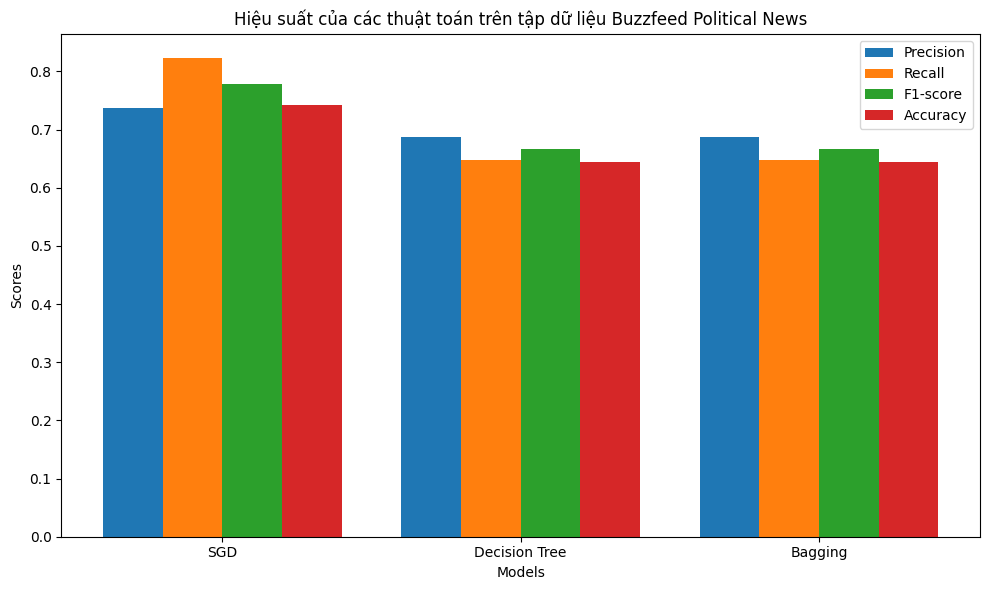

In [ ]:
data = {
    'Model': ['SGD', 'Decision Tree', 'Bagging'],
    'Precision': [precision_sgd, precision_tree, precision_bagging],
    'Recall': [recall_sgd, recall_tree, recall_bagging],
    'F1-score': [f1_sgd, f1_tree, f1_bagging],
    'Accuracy': [acc_sgd, acc_tree, acc_bagging]
}

# Tạo DataFrame
df = pd.DataFrame(data)

# Thiết lập vị trí các thanh
x = np.arange(len(df['Model']))
width = 0.2  # Độ rộng của các thanh

# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ các thanh cho từng chỉ số
rects1 = ax.bar(x - 1.5*width, df['Precision'], width, label='Precision')
rects2 = ax.bar(x - 0.5*width, df['Recall'], width, label='Recall')
rects3 = ax.bar(x + 0.5*width, df['F1-score'], width, label='F1-score')
rects4 = ax.bar(x + 1.5*width, df['Accuracy'], width, label='Accuracy')

# Thêm các chi tiết khác cho biểu đồ
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Hiệu suất của các thuật toán trên tập dữ liệu Buzzfeed Political News')
ax.set_xticks(x)
ax.set_xticklabels(df['Model'])
ax.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

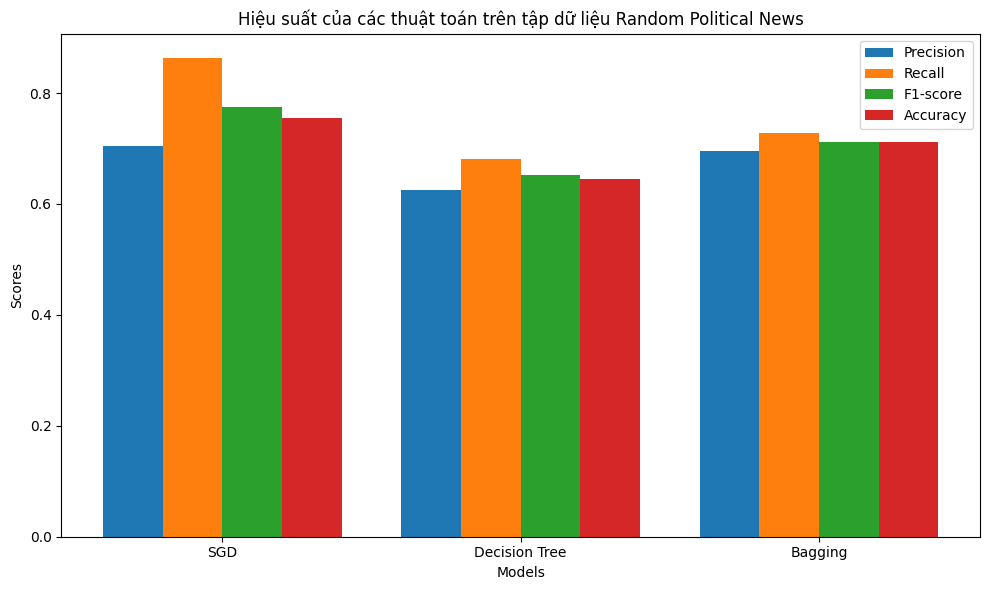

In [ ]:
data = {
    'Model': ['SGD', 'Decision Tree', 'Bagging'],
    'Precision': [precision_sgd1, precision_tree1, precision_bagging1],
    'Recall': [recall_sgd1, recall_tree1, recall_bagging1],
    'F1-score': [f1_sgd1, f1_tree1, f1_bagging1],
    'Accuracy': [acc_sgd1, acc_tree1, acc_bagging1]
}

# Tạo DataFrame
df = pd.DataFrame(data)

# Thiết lập vị trí các thanh
x = np.arange(len(df['Model']))
width = 0.2  # Độ rộng của các thanh

# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ các thanh cho từng chỉ số
rects1 = ax.bar(x - 1.5*width, df['Precision'], width, label='Precision')
rects2 = ax.bar(x - 0.5*width, df['Recall'], width, label='Recall')
rects3 = ax.bar(x + 0.5*width, df['F1-score'], width, label='F1-score')
rects4 = ax.bar(x + 1.5*width, df['Accuracy'], width, label='Accuracy')

# Thêm các chi tiết khác cho biểu đồ
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Hiệu suất của các thuật toán trên tập dữ liệu Random Political News')
ax.set_xticks(x)
ax.set_xticklabels(df['Model'])
ax.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

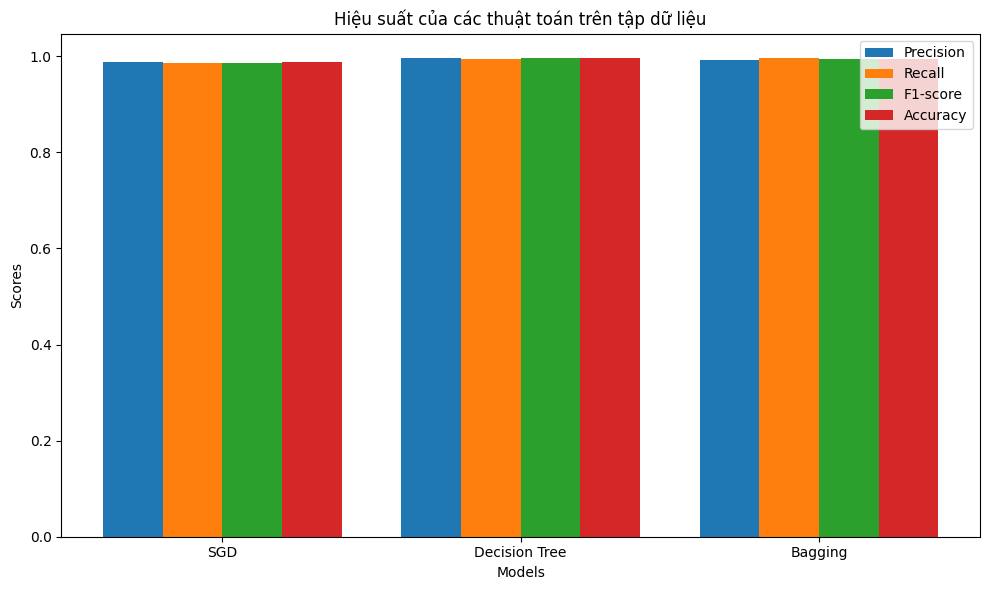

In [ ]:
data = {
    'Model': ['SGD', 'Decision Tree', 'Bagging'],
    'Precision': [precision_sgd2, precision_tree2, precision_bagging2],
    'Recall': [recall_sgd2, recall_tree2, recall_bagging2],
    'F1-score': [f1_sgd2, f1_tree2, f1_bagging2],
    'Accuracy': [acc_sgd2, acc_tree2, acc_bagging2]
}

# Tạo DataFrame
df = pd.DataFrame(data)

# Thiết lập vị trí các thanh
x = np.arange(len(df['Model']))
width = 0.2  # Độ rộng của các thanh

# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ các thanh cho từng chỉ số
rects1 = ax.bar(x - 1.5*width, df['Precision'], width, label='Precision')
rects2 = ax.bar(x - 0.5*width, df['Recall'], width, label='Recall')
rects3 = ax.bar(x + 0.5*width, df['F1-score'], width, label='F1-score')
rects4 = ax.bar(x + 1.5*width, df['Accuracy'], width, label='Accuracy')

# Thêm các chi tiết khác cho biểu đồ
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Hiệu suất của các thuật toán trên tập dữ liệu')
ax.set_xticks(x)
ax.set_xticklabels(df['Model'])
ax.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

                    Classifier  Accuracy  Precision    Recall  F1 Score
0                Decision Tree  0.761667   0.770000  0.774000  0.771667
1  Stochastic Gradient Descent  0.828000   0.809667  0.891333  0.850667
2                      Bagging  0.783333   0.791667  0.790000  0.790333


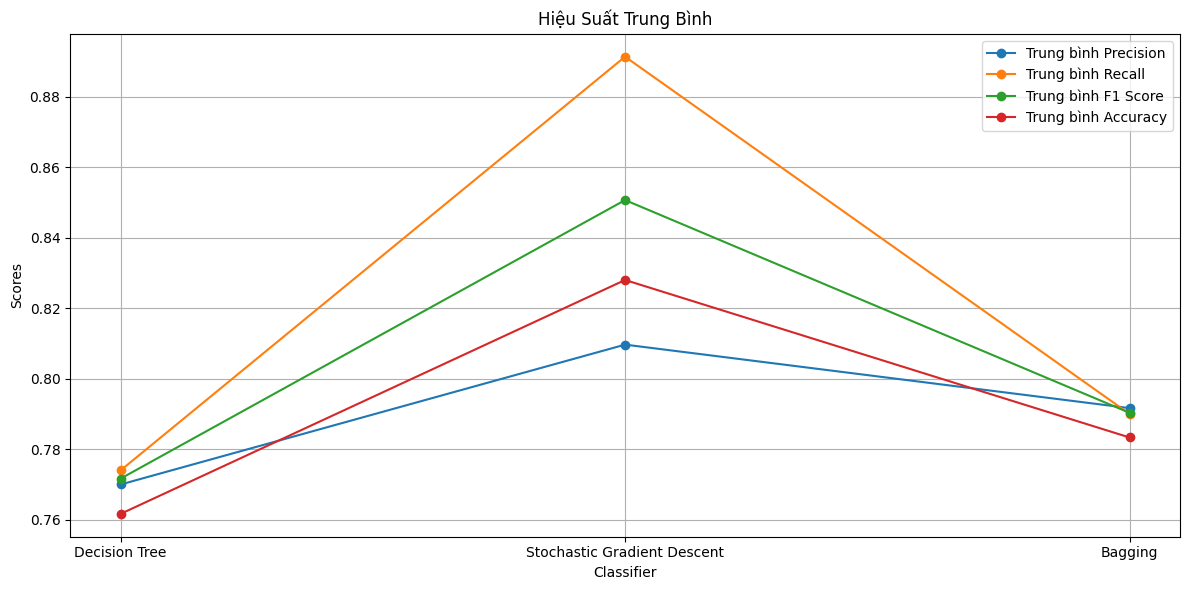

In [ ]:
# Dữ liệu từ bảng 3.5 - BuzzFeed Political News
data_buzzfeed = {
    'Classifier': ['Decision Tree', 'Stochastic Gradient Descent', 'Bagging'],
    'Accuracy': [0.645, 0.742, 0.645],
    'Precision': [0.688, 0.737, 0.688],
    'Recall': [0.647, 0.824, 0.647],
    'F1 Score': [0.667, 0.789, 0.667]
}

# Dữ liệu từ bảng 3.6 - Random Political News
data_random = {
    'Classifier': ['Decision Tree', 'Stochastic Gradient Descent', 'Bagging'],
    'Accuracy': [0.644, 0.755, 0.711],
    'Precision': [0.625, 0.704, 0.696],
    'Recall': [0.681, 0.864, 0.727],
    'F1 Score': [0.652, 0.776, 0.711]
}

# Dữ liệu từ bảng 3.7 - tập dữ liệu thứ ba
data_third = {
    'Classifier': ['Decision Tree', 'Stochastic Gradient Descent', 'Bagging'],
    'Accuracy': [0.996, 0.987, 0.994],
    'Precision': [0.997, 0.988, 0.991],
    'Recall': [0.994, 0.986, 0.996],
    'F1 Score': [0.996, 0.987, 0.993]
}

# Tạo DataFrame cho mỗi bảng
df_buzzfeed = pd.DataFrame(data_buzzfeed)
df_random = pd.DataFrame(data_random)
df_third = pd.DataFrame(data_third)

# Tính trung bình của các chỉ số hiệu suất cho mỗi bộ phân loại
df_mean = (df_buzzfeed.set_index('Classifier') + df_random.set_index('Classifier') + df_third.set_index('Classifier')) / 3

# In kết quả
print(df_mean.reset_index())

# Vẽ biểu đồ
classifiers = df_mean.index
precision_means = df_mean['Precision']
recall_means = df_mean['Recall']
f1_means = df_mean['F1 Score']
accuracy_means = df_mean['Accuracy']

plt.figure(figsize=(12, 6))
plt.plot(classifiers, precision_means, label='Trung bình Precision', marker='o')
plt.plot(classifiers, recall_means, label='Trung bình Recall', marker='o')
plt.plot(classifiers, f1_means, label='Trung bình F1 Score', marker='o')
plt.plot(classifiers, accuracy_means, label='Trung bình Accuracy', marker='o')

plt.xlabel('Classifier')
plt.ylabel('Scores')
plt.title('Hiệu Suất Trung Bình')
plt.legend()
plt.grid(True)
plt.xticks(rotation=0)  # Xoay nhãn theo chiều dọc
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()